## 라이브러리 로드

In [47]:
import os
import pandas as pd
import numpy as np

from hanspell import spell_checker
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Twitter
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

## 경로 지정

In [4]:
DATA_PATH_1 = f'data/data_genre/'

In [5]:
path = os.path.join(DATA_PATH_1, "melon_folkblues_인기_가사__12124.csv")
path
df= pd.read_csv(path)
df.shape

(12124, 4)

## Tf-idf

TF-IDF(Term Frequency-Inverse Document Frequency)는 단어의 빈도와 역 문서 빈도(문서의 빈도에 특정 식을 취함)를 사용하여

문서 단어 행렬 (Document-Term Matrix) 내의 단어들마다 중요한 정도를 가중치로 주는 방법입니다.

해당 지표를 통 가사에 활용하여 한 곡 내에서 어떤 단어들이 주로 등장하게 되는지 확인해 보도록 하겠습니다.

In [6]:
tfidf = TfidfVectorizer(max_features=500)
tdm = tfidf.fit_transform(df['가사'])

In [7]:
cv = CountVectorizer(max_features=500)
tdm2 = cv.fit_transform(df['가사'])

In [8]:
word_count = pd.DataFrame({
    '단어': cv.get_feature_names(),
    'tf-idf': tdm.sum(axis=0).flat
})

/Users/jihye/miniconda/envs/hello/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


어떤 단어가 높은 빈도로 등장하는 지 확인하도록 하겠습니다.

In [9]:
vocabs = word_count.sort_values('tf-idf', ascending=False)
top_30 = vocabs.head(30)
top_30.head()

,단어,tf-idf
87,나는,422.571437
98,내가,416.979526
49,그대,400.934262
93,나의,393.433936
110,너의,386.182274


대명사, 조사가 매우 많은 것을 확인할 수 있습니다.
다른 단어들의 분포 또한 확인하기 위해 Tf-idf 30위의 단어들에 대한 시각화를 진행합니다.

<AxesSubplot: xlabel='단어', ylabel='tf-idf'>

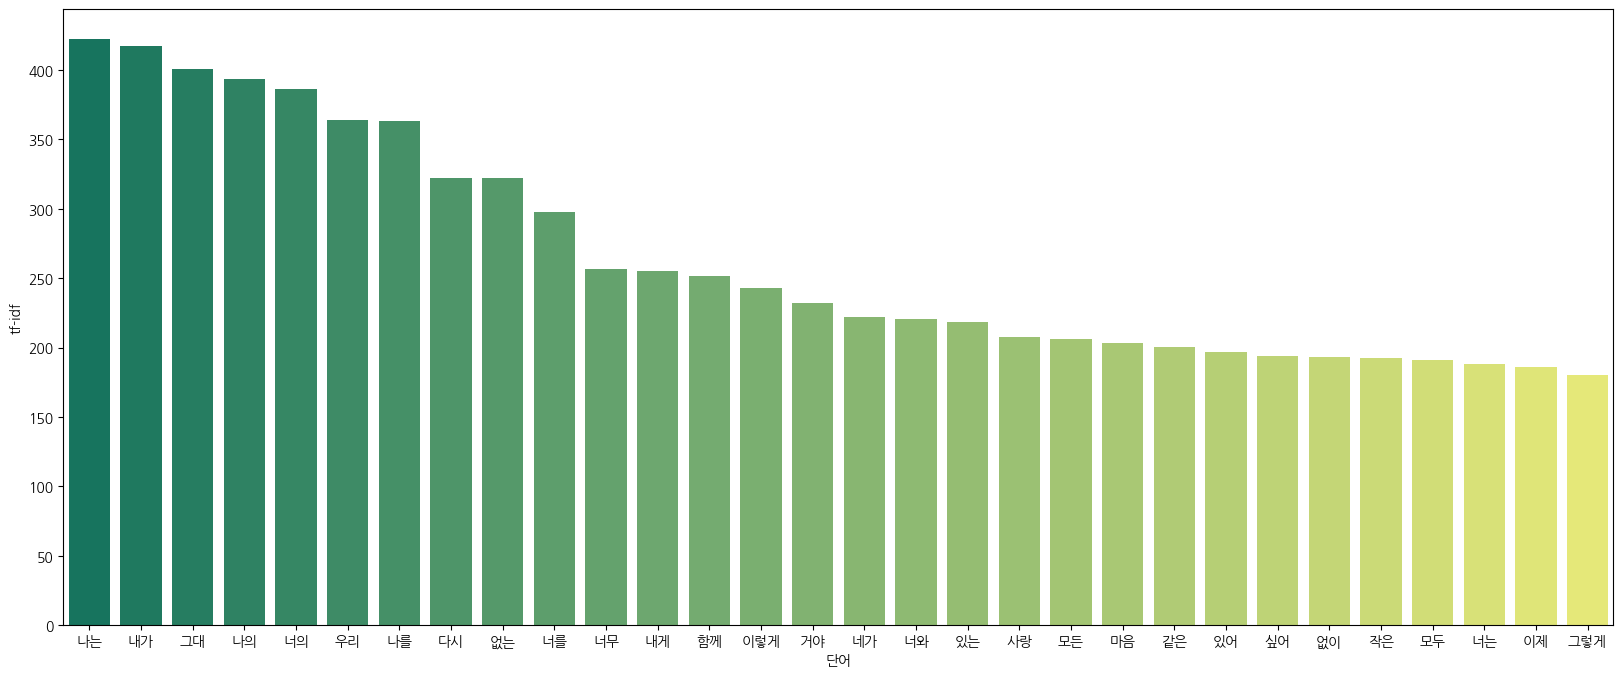

In [10]:
plt.figure(figsize=(20, 8))
sns.barplot(x="단어", y="tf-idf", data=top_30, palette='summer')

나와 상대를 지칭하는 표현들이 많은 것을 보아, 서로의 관계성에 대해 노래하거나 스스로의 감정을 표현하는 맥락이 많다는 것을 확인할 수 있습니다.

그러나 조사가 붙은 단어가 대부분이어서, 토크나이저를 활용하여 특정 형태소의 단어군을 추출할 필요가 있습니다.

## 명사 추출

형태소 분석을 위해 konlpy의 Okt 객체를 선언하여 사용하겠습니다.

Okt를 사용하면 띄어쓰기와 무관하게 명사만을 추출하게 됩니다.

In [11]:
# .csv 파일을 리스트로 만들어줍니다.

lst = []
for i in range(len(df["가사"])):
    for j in df["가사"].str.split("\n")[i]:
        lst.append(j)

In [12]:
# 리스트를 하나의 문자열로 연결해줍니다.
txt = '\n'.join(lst)

In [13]:
# 문자열을 okt 객체에 넣어, 가사에 사용된 명사들만을 추출합니다.
okt = Okt()
noun_lst = okt.nouns(txt)

In [14]:
# 명사로 이루어진 리스트들의 데이터 갯수를 카운트하여 딕셔너리로 반환합니다.
dict_noun = Counter(noun_lst).most_common(30)

In [15]:
df_noun = pd.DataFrame(dict_noun)
df_noun

,0,1
0,내,23322
1,너,23179
2,나,20676
3,사랑,17571
4,그대,13886
5,그,12342
6,말,12337
7,날,10560
8,우리,9695
9,난,9071


## 동사 추출

okt를 활용한 내용은 위와 같았습니다. 동사의 분포 또한 확인해보도록 하겠습니다.

삼행시를 제작하기 위해서는 다양한 동사의 분포를 확인해야 합니다.

유용하게 활용 될 수 있는 동사가 핵심 단어장에 적절하게 포함되어 있어야 하기 때문입니다.

okt 객체의 다른 형태소들을 분석해보기 위해서는 품사 태그를 따로 달아주어야 합니다.

In [20]:
okt = Okt()
noun_lst = okt.pos(txt)

In [34]:
okt_df = pd.DataFrame(noun_lst)
okt_df.columns=['단어', '품사']
okt_df = okt_df[okt_df['품사']=='Verb']
okt_df

In [48]:
wc = WordCloud(font_path='VITRO CORE')
count = Counter(okt_df['단어']) 
gen = wc.generate_from_frequencies(count)
plt.imshow(gen)

OSError: cannot open resource

결과를 확인하니 여전히 대명사가 많습니다. 다른 토크나이저를 활용하여 명사를 추출해보는 실험을 하겠습니다.

In [ ]:
from konlpy.tag import Kkma
kkma = Kkma()
noun_lst_2 = kkma.nouns(txt)

In [45]:
twt = Twitter()
tagging = twt.pos(txt)
tagging
twit_df = pd.DataFrame(tagging)

/Users/jihye/miniconda/envs/hello/lib/python3.10/site-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


## 가사 문장의 길이

In [49]:
# apply, lambda를 통해 문자, 단어 빈도수 파생변수 만들기
df["word_count"] = df['가사'].map(lambda x : len(x.split())) # split을 공백 기준으로 나눔
df["unique_word_count"] = df['가사'].map(lambda x: len(set(x.split())))

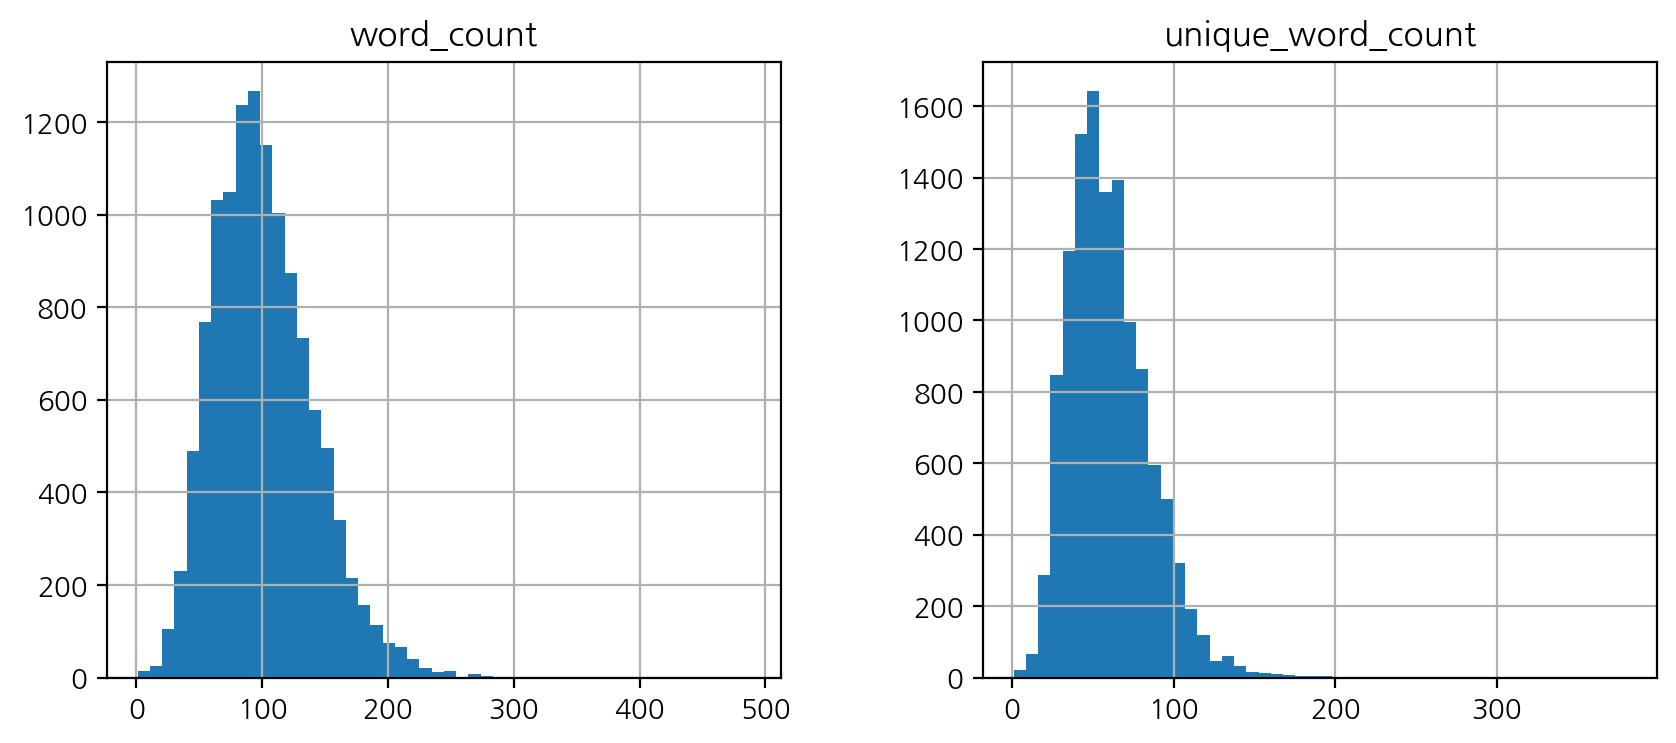

In [50]:
df[['단어의 갯수', 'unique_word_count']].hist(figsize=(10, 4), bins=50);

## 발라드 데이터 가사 분석

In [ ]:
DATA_PATH_2 = f'data/data_ballad/'

In [ ]:
path_2 = os.path.join(DATA_PATH_2, "melon_ballad_40001_50000.csv")
path_2
df_2 = pd.read_csv(path_2)
df_2.shape

(9181, 6)

In [ ]:
pd.set_option('display.width', 500)

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9181 entries, 0 to 9180
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      9181 non-null   object
 1   가사      9181 non-null   object
 2   가수      9181 non-null   object
 3   발매일     9181 non-null   object
 4   좋아요수    9181 non-null   object
 5   장르      9181 non-null   object
dtypes: object(6)
memory usage: 430.5+ KB


.dt 접근자로 접근하면 에러가 발생하여, 값에 대해 확인했다.

In [ ]:
df_2['발매일'].value_counts(ascending=False).head(5)

1994          35
1999.01.01    26
1997          25
-             24
2002.02.09    19
Name: 발매일, dtype: int64

In [ ]:
df_2["발매연도"] = df_2["발매일"].dt.year
df_2["발매월"] = df_2["발매일"].dt.month
df_2["발매일"] = df_2["발매일"].dt.day
df_2["발매요일"] = df_2["발매일"].dt.dayofweek
df_2.head()

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
df_2.dtypes

제목      object
가사      object
가수      object
발매일     object
좋아요수    object
장르      object
발매연도    object
발매월     object
dtype: object

In [ ]:
df = df.dropna()

In [ ]:
df = df.astype({'발매연도': 'int', '발매월': 'int', '발매일': 'int'})

In [ ]:
from konlpy.tag import Mecab

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
%env JAVA_HOME "/Library/Java/JavaVirtualMachines/adoptopenjdk-11.jdk"

env: JAVA_HOME="/Library/Java/JavaVirtualMachines/adoptopenjdk-11.jdk"


In [ ]:
JVM_PATH = '/Library/Java/JavaVirtualMachines/adoptopenjdk-11.jdk/Contents/Home/bin/java'

In [ ]:
from konlpy.tag import Okt
okt = Okt()

FileNotFoundError: [Errno 2] JVM DLL not found: /Library/Java/JavaVirtualMachines/adoptopenjdk-11.jdk/Contents/Home/lib/jli/libjli.dylib


In [ ]:
tfidf = TfidfVectorizer(max_features=500)
tdm = tfidf.fit_transform(df['가사'])